## Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import loads
from sklearn.cluster import KMeans
import numpy as np

## Read In and Format Data

In [85]:
gdf = gpd.read_file("../data/SANGIS/BUSINESS_SITES/BUSINESS_SITES.shp")
gdf = gdf.to_crs(crs='EPSG:4326')
gdf = gdf[gdf['POINT_X']!=0]
gdf['x'] = gdf['geometry'].x
gdf['y'] = gdf['geometry'].y

## Bin Data into ~1/4 Hexbins


(note - gridsize was manually calculated based on width of SD County to generate roughly 1/4 mile radius hexbins:
SD County is roughly 86 miles east to west, and the grid size takes the quantity of hexbins by width
)

In [86]:
labels = pd.read_csv('../generate_labels.csv')
final_merge = gdf.merge(labels, how='left', left_on='BUSTYPE',right_on='Items')
final_merge = final_merge[~final_merge['Categories'].isna()]

In [128]:
import geopandas as gpd
import h3pandas as h3pd
import matplotlib.pyplot as plt


/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_2123/3604080983.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df3['x'] = df3['geometry'].centroid.x
/var/folders/9y/511s41v52w36jc3xv1hv8l2m0000gn/T/ipykernel_2123/3604080983.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df3['y'] = df3['geometry'].centroid.y


Merge the data with the newly generated hexbins

## Use the 70 Largest Hexbins as 'Centers' For Clustering

In [152]:
df2 = final_merge[final_merge['Categories']==i].h3.geo_to_h3(10)
df2['lng']=df2['x']
df2['lat']=df2['y']
df2['Count']=1
df3 = df2[['lng','lat','Count']].reset_index().h3.geo_to_h3_aggregate(10, return_geometry=False).h3.h3_to_parent_aggregate(9)
df3['x'] = df3['geometry'].centroid.x
df3['y'] = df3['geometry'].centroid.y
df = df3
df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
cluster_centers = df[df['is_center']==True][['x', 'y']].values
other_points = df[['x', 'y']].values
k = len(cluster_centers)
kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
kmeans.fit(other_points)
df['cluster'] = kmeans.labels_
df.dissolve(by='cluster',aggfunc='sum').explore()

In [158]:
df['geometry']

h3_09
8929a09b08fffff    POLYGON ((-117.19516 33.42795, -117.19402 33.4...
8929a09b577ffff    POLYGON ((-117.21594 33.42745, -117.21480 33.4...
8929a09b5a7ffff    POLYGON ((-117.22972 33.42044, -117.22859 33.4...
8929a400027ffff    POLYGON ((-117.24497 32.83263, -117.24384 32.8...
8929a400033ffff    POLYGON ((-117.24148 32.82770, -117.24034 32.8...
                                         ...                        
8929a6b8043ffff    POLYGON ((-116.37957 33.25308, -116.37842 33.2...
8929a6b8047ffff    POLYGON ((-116.38305 33.25469, -116.38189 33.2...
8929a6b804bffff    POLYGON ((-116.37611 33.25482, -116.37495 33.2...
8929a6bb6a3ffff    POLYGON ((-116.32745 33.19216, -116.32629 33.1...
89485926113ffff    POLYGON ((-116.60609 32.62344, -116.60495 32.6...
Name: geometry, Length: 2310, dtype: geometry

,geometry,Count,x,y,is_center
cluster,,,,,
0,"MULTIPOLYGON (((-117.22987 32.81460, -117.2275...",17,-1406.659314,393.852752,0
1,"MULTIPOLYGON (((-117.24003 32.79597, -117.2412...",50,-1289.552481,360.809605,2
2,"MULTIPOLYGON (((-117.20551 32.78675, -117.2066...",44,-1406.450599,393.626936,1
3,"MULTIPOLYGON (((-117.24380 32.83099, -117.2415...",14,-1055.233392,295.613332,0
4,"POLYGON ((-117.26802 32.84211, -117.26915 32.8...",63,-820.909714,229.922395,3
...,...,...,...,...,...
73,"MULTIPOLYGON (((-117.19451 33.09774, -117.1956...",94,-5975.546911,1690.161654,0
74,"MULTIPOLYGON (((-117.09469 32.57010, -117.0935...",129,-6673.116216,1857.556503,0
75,"MULTIPOLYGON (((-116.99377 32.56558, -116.9949...",138,-5965.962827,1663.757398,3


## Function to generate outputs on slice of data

In [19]:
import random
samples =[0]
[0]*5
range(5)
samples[random.choices(range(1), [.05], k=1)[0]]+=1
samples
list(range(5))

[0, 1, 2, 3, 4]

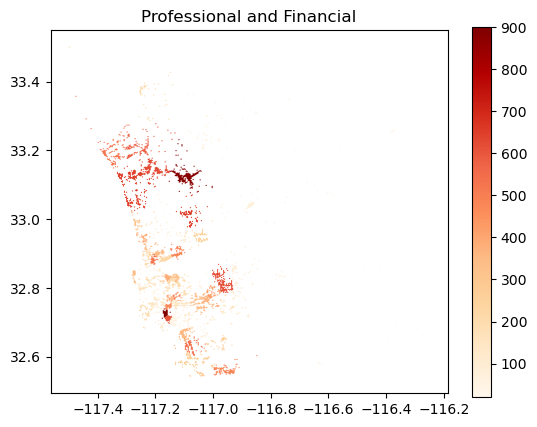

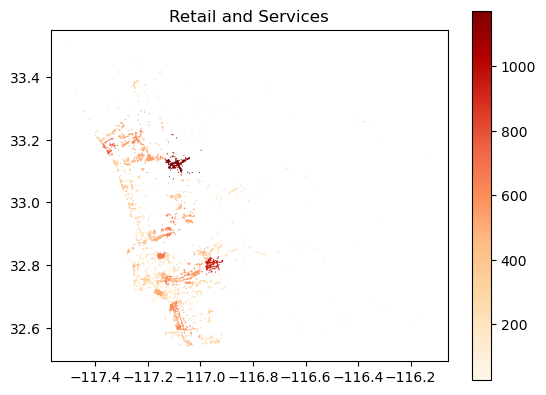

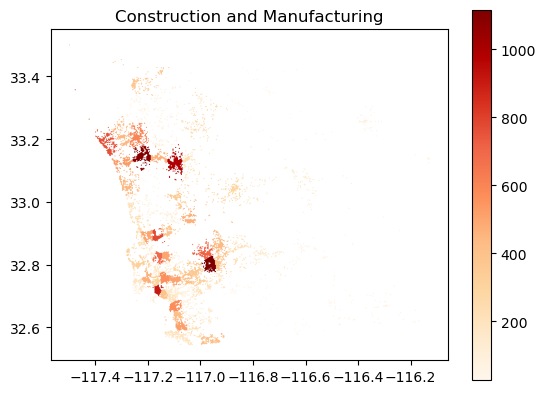

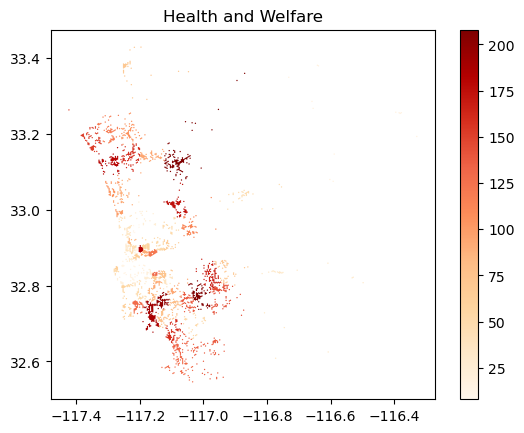

In [151]:
import warnings
warnings.filterwarnings('ignore')
for i in final_merge['Categories'].unique():
    df2 = final_merge[final_merge['Categories']==i].h3.geo_to_h3(10)
    df2['lng']=df2['x']
    df2['lat']=df2['y']
    df2['Count']=1
    df3 = df2[['lng','lat','Count']].reset_index().h3.geo_to_h3_aggregate(10, return_geometry=False).h3.h3_to_parent_aggregate(9)
    df3['x'] = df3['geometry'].centroid.x
    df3['y'] = df3['geometry'].centroid.y
    df = df3
    df['is_center'] = df['Count']>=df['Count'].sort_values(ascending=False).reset_index(drop=True)[70]
    cluster_centers = df[df['is_center']==True][['x', 'y']].values
    other_points = df[['x', 'y']].values
    k = len(cluster_centers)
    kmeans = KMeans(n_clusters=k, init=cluster_centers, n_init=1)
    kmeans.fit(other_points)
    df['cluster'] = kmeans.labels_
    df.dissolve(by='cluster',aggfunc='sum').plot(column='Count',legend=True,cmap='OrRd').set_title(i)

<Axes: ylabel='Frequency'>

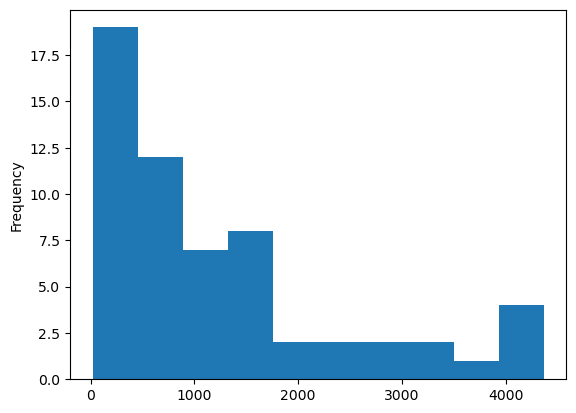

In [98]:
dissolved['count'].plot(kind='hist')